In [ ]:
#import libarries dan Bikin Arsitektur


%tensorflow_version 1.x
import keras
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Dense
from keras.layers.core import Activation
from keras.layers.advanced_activations import ELU
from keras.layers.core import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import concatenate
from keras.models import Model
from keras.regularizers import l2
from keras import backend as K

class GoogLeNet:
    @staticmethod
    def conv_module(x, K, kX, kY, stride, chanDim,
        padding = "same", reg = 0.0005, name = None):
        # initialize the CONV, BN, and RELU layer names
        (convName, bnName, actName) = (None, None, None)

        # if a layer name was supplied, prepend it
        if name is not None:
            convName = name + "_conv"
            bnName = name + "_bn"
            actName = name + "_act"

        # define a CONV => BN => RELU pattern
        x = Conv2D(K, (kX, kY), strides = stride, padding = padding,
            kernel_regularizer = l2(reg), name = convName)(x)
        x = BatchNormalization(axis = chanDim, name = bnName)(x)
        x = Activation("relu", name = actName)(x)

        # return the block
        return x

    @staticmethod
    def inception_module(x, num1x1, num3x3Reduce, num3x3, num5x5Reduce,
        num5x5, num1x1Proj, chanDim, stage, reg = 0.0005):
        # define the first branch of the Inception module which
        # consists of 1x1 convolutions
        first = GoogLeNet.conv_module(x, num1x1, 1, 1, (1, 1),
            chanDim, reg = reg, name = stage + "_first")

        # define the second branch of the Inception module which
        # consists of 1x1 and 3x3 convolutions
        second = GoogLeNet.conv_module(x, num3x3Reduce, 1, 1, (1, 1),
            chanDim, reg = reg, name = stage + "_second1")
        second = GoogLeNet.conv_module(second, num3x3, 3, 3, (1, 1),
            chanDim, reg = reg, name = stage + "_second2")

        # define the third branch of the Inception module which
        # are both 1x1 and 5x5 convolutions
        third = GoogLeNet.conv_module(x, num5x5Reduce, 1, 1, (1, 1),
            chanDim, reg = reg, name = stage + "_third1")
        third = GoogLeNet.conv_module(third, num5x5, 5, 5, (1, 1),
            chanDim, reg = reg, name = stage + "_third2")

        # define the fourth branch of the Inception module which
        # is the POOL projection
        fourth = MaxPooling2D((3, 3), strides = (1, 1), padding = "same",
            name = stage + "_pool")(x)
        fourth = GoogLeNet.conv_module(fourth, num1x1Proj, 1, 1, (1, 1),
            chanDim, reg = reg, name = stage + "_fourth")

        # concatenate across the channel dimension
        x = concatenate([first, second, third, fourth], axis = chanDim,
            name = stage + "_mixed")

        # return the block
        return x

    @staticmethod
    def build(width, height, depth, classes, reg = 0.0005):
        # initialize the input shape to be "channel last" and the
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channel first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # define the model input, followed by a sequence of
        # CONV => POOL => (CONV * 2) => POOL layers
        inputs = Input(shape = inputShape)
        x = GoogLeNet.conv_module(inputs, 64, 5, 5, (1, 1),
            chanDim, reg = reg, name = "block1")
        x = MaxPooling2D((3, 3), strides = (2, 2), padding = "same",
            name = "pool1")(x)
        x = GoogLeNet.conv_module(x, 64, 1, 1, (1, 1),
            chanDim, reg = reg, name = "block2")
        x = GoogLeNet.conv_module(x, 192, 3, 3, (1, 1),
            chanDim, reg = reg, name = "block3")
        x = MaxPooling2D((3, 3), strides = (2, 2), padding = "same",
            name = "pool2")(x)

        # apply two Inception module followed by a POOL
        x = GoogLeNet.inception_module(x, 64, 96, 128, 16, 32, 32,
            chanDim, "3a", reg = reg)
        x = GoogLeNet.inception_module(x, 128, 128, 192, 32, 96, 64,
            chanDim, "3b", reg = reg)
        x = MaxPooling2D((3, 3), strides = (2, 2), padding = "same",
            name = "pool3")(x)

        # apply five Inception module followed by POOL
        x = GoogLeNet.inception_module(x, 192, 96, 208, 16, 48, 64,
            chanDim, "4a", reg = reg)
        x = GoogLeNet.inception_module(x, 160, 112, 224, 24, 64, 64,
            chanDim, "4b", reg = reg)
        x = GoogLeNet.inception_module(x, 128, 128, 256, 24, 64, 64,
            chanDim, "4c", reg = reg)
        x = GoogLeNet.inception_module(x, 112, 144, 288, 32, 64, 64,
            chanDim, "4d", reg = reg)
        x = GoogLeNet.inception_module(x, 256, 160, 320, 32, 128, 128,
            chanDim, "4e", reg = reg)
        x = MaxPooling2D((3, 3), strides = (2, 2), padding = "same",
            name = "pool4")(x)

        # apply last two Inception module
        x = GoogLeNet.inception_module(x, 256, 160, 320, 32, 128, 128,
            chanDim, "5a", reg = reg)
        x = GoogLeNet.inception_module(x, 384, 192, 384, 48, 128, 128,
            chanDim, "5b", reg = reg)

        # apply a POOL layer (average) followed by dropout
        x = AveragePooling2D((4, 4), name = "pool5")(x)
        x = Dropout(0.4, name = "do")(x)

        # softmax classifier
        x = Flatten(name = "flatten")(x)
        #x = layers.Dropout(0.5)(x)
        x = Dense(classes, kernel_regularizer = l2(reg), name = "labels")(x)
        x = Activation("softmax", name = "softmax")(x)

        # create the model
        model = Model(inputs, x, name = "googlenet")

        # return the constructed network architecture
        return model

TensorFlow is already loaded. Please restart the runtime to change versions.


Using TensorFlow backend.


In [ ]:
#link ke google drive

%tensorflow_version 1.x
import keras
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.optimizers import Adam, SGD

from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from imutils import paths
import os



from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
#### Updated ####

#### Updated ####
### The following two lines caused the issue:
import sys
#sys.path.append('/content/gdrive/My Drive/ColabNotebooks')
sys.path.append('/content/gdrive/My Drive')

### Replacing the above with these two lines solved the issue:
import os
#os.chdir('/content/gdrive/My Drive/ColabNotebooks') # Ch working directory to project folder
os.chdir('/content/gdrive/My Drive') # Ch working directory to project folder

###

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#setting path gambar di gdrive

print("[INFO] loading images...")
#imagePaths = paths.list_images('DATA SET TA')
imagePaths = paths.list_images('Data Set TA')

#imagePaths = paths.list_images('Dataset150')

data = []
labels = []
gambar = []
val = []
labels3 = []
aug = []
labels2 = []

[INFO] loading images...


In [ ]:
#ambil dataset Asli tanpa augmen warna

for imagePath in imagePaths:

  a = Image.open(imagePath)
  image = np.array(a.resize((224,224))) / 255.0
  data.append(image)

  label = imagePath.split(os.path.sep) [-2]
  labels.append(label)

In [ ]:
#Function buat Augmentasi
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [ ]:
#ini cuma buat ngecek 

imagePaths = 'Data Set TA'


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

train_generator = train_datagen.flow_from_directory(
        imagePaths,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 880 images belonging to 11 classes.


In [ ]:
#masukin gambar warna dengan augmentasi dan asli 

for imagePath in imagePaths:

  a = Image.open(imagePath)
  image = np.array(a.resize((224,224))) / 255.0
  x = image

  data.append(x)
  label = imagePath.split(os.path.sep) [-2]
  labels.append(label)

  aug.append(x)
  x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
  
  i = 0
  label = imagePath.split(os.path.sep) [-2]
  labels2.append(label)
  for batch in datagen.flow(x, batch_size=1):
    mas = x[0,:,:,:] #( 150, 150, 3)
    aug.append(mas)
    label = imagePath.split(os.path.sep) [-2]
    labels2.append(label)
    i += 1
    if i % 3 == 0:
      break 
  


In [ ]:
import numpy as np


a=np.array([[600. ,753.],[593., 753.]])
len(a)

2

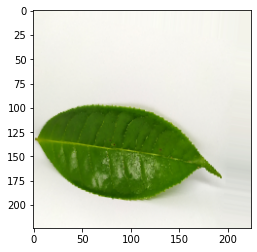

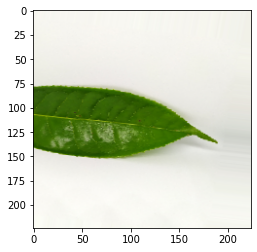

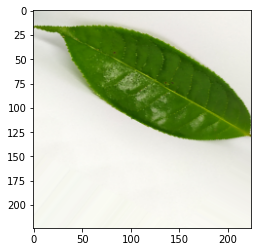

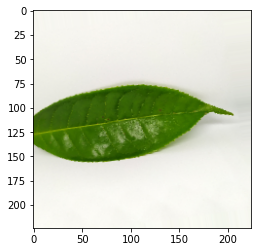

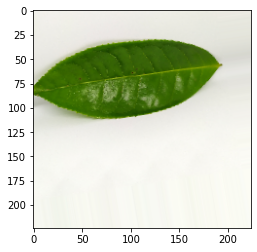

In [ ]:
(#ini cuma buat ngetes
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

gambarcek = os.listdir('Data Set TA/GMB2')
img_path = os.path.join('Data Set TA/GMB2', gambarcek[2])
img = load_img(img_path, target_size=(224, 224))  # this is a PIL image
x = np.array(img) 
# Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

In [ ]:
#membuat dan memasukkan gambar gray pake CLAHE dengan augmentasi dan asli
#note: pilih salah satu warna apa gray


import cv2

for imagePath in imagePaths:


  a = Image.open(imagePath)

  a = a.convert('L')


  image = np.array(a.resize((224,224))) 

  clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))

  image = clahe.apply(image)

  image = image / 255.0
  
  image = np.expand_dims(image, axis=-1)


  x = image

  data.append(x)
  label = imagePath.split(os.path.sep) [-2]
  labels.append(label)

  aug.append(x)
  x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
  
  i = 0
  label = imagePath.split(os.path.sep) [-2]
  labels2.append(label)
  for batch in datagen.flow(x, batch_size=1):
    mas = x[0,:,:,:] #( 150, 150, 3)
    aug.append(mas)
    label = imagePath.split(os.path.sep) [-2]
    labels2.append(label)
    i += 1
    if i % 3 == 0:
      break 
  


In [ ]:
#buat ngecek
a.shape

AttributeError: ignored

In [ ]:
#buat ngetes Clahe

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

gambarcek = os.listdir('Data Set TA/GMB3')
img_path = os.path.join('Data Set TA/GMB3', gambarcek[1])
img = load_img('Data Set TA/GMB3/DG3 (1).jpg', target_size=(224, 224))

img=img.convert('L')


#def rgb2gray(rgb):
#    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

#clahe
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))




  # this is a PIL image
x = np.array(img) 
#hasil clahe
cli1 = clahe.apply(x)
#x = rgb2gray(x) # Numpy array with shape (150, 150, 3)
x = np.expand_dims(x, axis=-1)
cli1 = np.expand_dims(cli1, axis=-1)


#x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
#cli1 = cli1.reshape((1,) + cli1.shape)  # Numpy array with shape (1, 150, 150, 3)


#bandingin
#asli
plt.figure(0)
imgplot = plt.imshow(array_to_img(x),cmap=plt.get_cmap('gray'))
#clahe
plt.figure(1)
imgplot = plt.imshow(array_to_img(cli1),cmap=plt.get_cmap('gray'))


# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
#for batch in datagen.flow(x, batch_size=1):
#  plt.figure(i)
#  imgplot = plt.imshow(array_to_img(batch[0]),cmap=plt.get_cmap('gray'))
#  i += 1
#  if i % 5 == 0:
#    break

In [ ]:
#validasi

In [ ]:
#print("[INFO] loading validation image...")
#imagePaths = paths.list_images('DATA SET TA')
#imagePaths2 = paths.list_images('Data Validasi')

#imagePaths = paths.list_images('Dataset150')

#validasi = []
#labels3 = []

[INFO] loading validation image...


In [ ]:
#for imagePath2 in imagePaths2:

  a = Image.open(imagePath2)
  image = np.array(a.resize((224,224))) / 255.0
  validasi.append(image)

  label3 = imagePath2.split(os.path.sep) [-2]
  labels3.append(label3)

In [ ]:
#ini one hot encodingnya dataset pake augmentasi, bisa dipake warna dan gray
print(labels2)
lb = LabelBinarizer()
labels2 = lb.fit_transform(labels2)
print(labels2)

['GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1',

In [ ]:
#ini one hot encodingnya dataset pake augmentasi, bisa dipake warna dan gray
lb = LabelBinarizer()
labels3 = lb.fit_transform(labels3)
print(labels3)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [ ]:
#ini one hot encoding dataset tanpa augmentasi, 
print(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(labels)

['GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB1', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2', 'GMB2',

In [ ]:
#ini set data Train dan Test kalau pakai dataset asli aja
(trainX,testX, trainY, testY) = train_test_split(np.array(data),
np.array(labels), test_size=0.2)
print(trainX.shape)
print(testX.shape)
#kalau pakai ini yg bawah gak usah di run

(704, 224, 224, 3)
(176, 224, 224, 3)


In [ ]:
#ini set data Train kalau pake augmen

(trainX,dumbx, trainY, dumby) = train_test_split(np.array(aug),
np.array(labels2), test_size=1)
print(trainX.shape)
print(trainY.shape)


(3516, 224, 224, 3)
(3516, 11)


In [ ]:
#ini set data Test kalau pake augmen
#ini dan cell atas harus di run

(dumbx,testX, dumby, testY) = train_test_split(np.array(data),
np.array(labels), test_size=1)
print(testX.shape)
print(testY.shape)

(1, 224, 224, 3)
(1,)


In [ ]:
#ini set data Test kalau pake augmen
#ini dan cell atas harus di run

(dumbx,testX, dumby, testY) = train_test_split(np.array(validasi),
np.array(labels3), test_size=219)
print(testX.shape)
print(testY.shape)

(219, 224, 224, 3)
(219, 11)


In [ ]:
#setting arsi dan opt
model = GoogLeNet.build(width = 224, height = 224, depth = 3,
        classes = 11, reg = 0.0002)
opt = SGD(lr = 1e-3)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [ ]:
#cek arsi
model.summary()

In [ ]:
#from sklearn.tree import DecisionTreeClassifier
#model = DecisionTreeClassifier()
#running
e = 155
b = 32

H=model.fit(trainX, trainY,validation_data=(testX, testY), batch_size=b, epochs=e, shuffle=True )
predY=model.predict(testX)
print("\n Evaluate the new model against the test set:")
model.evaluate(x=testX, y=testY, batch_size=32)
list_of_metrics_to_plot = ['accuracy']


Train on 704 samples, validate on 176 samples
Epoch 1/155
704/704 [==============================] - 7s 10ms/step - loss: 2.0901 - accuracy: 0.9560 - val_loss: 3.3553 - val_accuracy: 0.3864
Epoch 2/155
704/704 [==============================] - 7s 10ms/step - loss: 2.0937 - accuracy: 0.9432 - val_loss: 3.2858 - val_accuracy: 0.4375
Epoch 3/155
704/704 [==============================] - 7s 10ms/step - loss: 2.0517 - accuracy: 0.9616 - val_loss: 3.3604 - val_accuracy: 0.3807
Epoch 4/155
704/704 [==============================] - 7s 10ms/step - loss: 2.0328 - accuracy: 0.9602 - val_loss: 3.2860 - val_accuracy: 0.4148
Epoch 5/155
704/704 [==============================] - 7s 10ms/step - loss: 2.0246 - accuracy: 0.9545 - val_loss: 3.3524 - val_accuracy: 0.3920
Epoch 6/155
704/704 [==============================] - 7s 10ms/step - loss: 2.0640 - accuracy: 0.9631 - val_loss: 3.3144 - val_accuracy: 0.4091
Epoch 7/155
704/704 [==============================] - 7s 10ms/step - loss: 1.9992 - accur

KeyboardInterrupt: ignored

In [ ]:
#evaluasi
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))





[INFO] evaluating network...
              precision    recall  f1-score   support

        GMB1       0.59      0.53      0.56        19
       GMB10       0.25      0.21      0.23        14
       GMB11       0.35      0.41      0.38        17
        GMB2       0.42      0.73      0.53        11
        GMB3       0.56      0.59      0.57        17
        GMB4       0.40      0.67      0.50        12
        GMB5       0.30      0.43      0.35        14
        GMB6       0.75      0.50      0.60        18
        GMB7       0.42      0.47      0.44        17
        GMB8       0.62      0.56      0.59        18
        GMB9       1.00      0.16      0.27        19

    accuracy                           0.47       176
   macro avg       0.51      0.48      0.46       176
weighted avg       0.54      0.47      0.46       176



In [ ]:
#evaluasi 2
test_score = model.evaluate(testX, testY, batch_size = 32)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

In [ ]:
#function buat bikin grafik antara epoch dan metric
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

In [ ]:
#bikin grafik epoch sama Val_acc
from matplotlib import pyplot as plt
import pandas as pd

epochs = H.epoch
hist = pd.DataFrame(H.history)
list_of_metrics_to_plot = ['val_acc']
plot_curve(epochs, hist, list_of_metrics_to_plot)


In [ ]:
#grafik val_acc sama train_acc
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot([None] + H.history['acc'], 'o-')
ax.plot([None] + H.history['val_acc'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

In [ ]:
#grafik loss train dengan loss val
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot([None] + H.history['loss'], 'o-')
ax.plot([None] + H.history['val_loss'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train Loss', 'Validation Loss'], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
#Bikin Confusion
from sklearn.metrics import confusion_matrix

labels=["GMB1", "GMB2", "GMB3","GMB4","GMB5","GMB6","GMB7","GMB8","GMB9","GMB10","GMB11"]
print(confusion_matrix(testY, predY))


In [ ]:
#run 
from sklearn.metrics import multilabel_confusion_matrix
cm=multilabel_confusion_matrix(testY,predY)
print(cm)


In [ ]:
#run
from sklearn.metrics import multilabel_confusion_matrix

predY[1]
rounded_labels=np.argmax(predY, axis=1)
rounded_labels[1]
rounded_predict=np.argmax(testY, axis=1)
rounded_predict[1]
print(confusion_matrix(rounded_labels, rounded_predict))


In [ ]:
#run
rounded_labels[:,2]


In [ ]:
#gambar confusion matrix
cm = confusion_matrix(rounded_labels,  rounded_predict)
plot_confusion_matrix(cm)

In [ ]:
#run ini dulu baru atas
import numpy as np


def plot_confusion_matrix(cm,
                          target_names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    if normalize:
      plt.imshow(cm/7, interpolation='nearest', cmap=cmap)
    else:
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
def conv_module(x, K, kX, kY, stride, chanDim,
        padding = "same", reg = 0.0005, name = None):
        # initialize the CONV, BN, and RELU layer names
        (convName, bnName, actName) = (None, None, None)

        # if a layer name was supplied, prepend it
        if name is not None:
            convName = name + "_conv"
            bnName = name + "_bn"
            actName = name + "_act"

        # define a CONV => BN => RELU pattern
        x = Conv2D(K, (kX, kY), strides = stride, padding = padding,
            kernel_regularizer = l2(reg), name = convName)(x)
        x = BatchNormalization(axis = chanDim, name = bnName)(x)
        x = Activation("relu", name = actName)(x)

        # return the block
        return x

def inception_module(x, num1x1, num3x3Reduce, num3x3, num5x5Reduce,
        num5x5, num1x1Proj, chanDim, stage, reg = 0.0005):
        # define the first branch of the Inception module which
        # consists of 1x1 convolutions
        first = GoogLeNet.conv_module(x, num1x1, 1, 1, (1, 1),
            chanDim, reg = reg, name = stage + "_first")

        # define the second branch of the Inception module which
        # consists of 1x1 and 3x3 convolutions
        second = GoogLeNet.conv_module(x, num3x3Reduce, 1, 1, (1, 1),
            chanDim, reg = reg, name = stage + "_second1")
        second = GoogLeNet.conv_module(second, num3x3, 3, 3, (1, 1),
            chanDim, reg = reg, name = stage + "_second2")

        # define the third branch of the Inception module which
        # are both 1x1 and 5x5 convolutions
        third = GoogLeNet.conv_module(x, num5x5Reduce, 1, 1, (1, 1),
            chanDim, reg = reg, name = stage + "_third1")
        third = GoogLeNet.conv_module(third, num5x5, 5, 5, (1, 1),
            chanDim, reg = reg, name = stage + "_third2")

        # define the fourth branch of the Inception module which
        # is the POOL projection
        fourth = MaxPooling2D((3, 3), strides = (1, 1), padding = "same",
            name = stage + "_pool")(x)
        fourth = GoogLeNet.conv_module(fourth, num1x1Proj, 1, 1, (1, 1),
            chanDim, reg = reg, name = stage + "_fourth")

        # concatenate across the channel dimension
        x = concatenate([first, second, third, fourth], axis = chanDim,
            name = stage + "_mixed")

        # return the block
        return x

width = 224
height = 224
depth = 3
classes = 11
reg = 0.0005
chanDim = -1

        # if we are using "channel first", update the input shape
        # and channels dimension


        # define the model input, followed by a sequence of
        # CONV => POOL => (CONV * 2) => POOL layers
inputs = Input(shape=(224, 224, 3))
x = conv_module(inputs, 64, 5, 5, (1, 1), chanDim, reg = reg, name = "block1")
x = MaxPooling2D((3, 3), strides = (2, 2), padding = "same", name = "pool1")(x)
x = conv_module(x, 64, 1, 1, (1, 1), chanDim, reg = reg, name = "block2")
x = conv_module(x, 192, 3, 3, (1, 1), chanDim, reg = reg, name = "block3")
x = MaxPooling2D((3, 3), strides = (2, 2), padding = "same",name = "pool2")(x)

        # apply two Inception module followed by a POOL
x = inception_module(x, 64, 96, 128, 16, 32, 32, chanDim, "3a", reg = reg)
x = inception_module(x, 128, 128, 192, 32, 96, 64, chanDim, "3b", reg = reg)
x = MaxPooling2D((3, 3), strides = (2, 2), padding = "same", name = "pool3")(x)

        # apply five Inception module followed by POOL
x = inception_module(x, 192, 96, 208, 16, 48, 64, chanDim, "4a", reg = reg)
x = inception_module(x, 160, 112, 224, 24, 64, 64, chanDim, "4b", reg = reg)
x = inception_module(x, 128, 128, 256, 24, 64, 64, chanDim, "4c", reg = reg)
x = inception_module(x, 112, 144, 288, 32, 64, 64, chanDim, "4d", reg = reg)
x = inception_module(x, 256, 160, 320, 32, 128, 128, chanDim, "4e", reg = reg)
x = MaxPooling2D((3, 3), strides = (2, 2), padding = "same", name = "pool4")(x)

        # apply last two Inception module
x = inception_module(x, 256, 160, 320, 32, 128, 128, chanDim, "5a", reg = reg)
x = inception_module(x, 384, 192, 384, 48, 128, 128, chanDim, "5b", reg = reg)

        # apply a POOL layer (average) followed by dropout
x = AveragePooling2D((4, 4), name = "pool5")(x)
x = Dropout(0.4, name = "do")(x)

        # softmax classifier
x = Flatten(name = "flatten")(x)
        #x = layers.Dropout(0.5)(x)
x = Dense(classes, kernel_regularizer = l2(reg), name = "labels")(x)
x = Activation("softmax", name = "softmax")(x)

        # create the model
model = Model(inputs, x, name = "googlenet")


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
inputsz = Input(shape=(224, 224, 3))
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(inputsz, successive_outputs, name = "googlenet")

img = load_img('Data Set TA/GMB3/DG3 (1).jpg', target_size=(224, 224))

x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

ValueError: ignored

In [ ]:
feature_map

In [ ]:
img = load_img('Data Set TA/GMB6/DG6 (25).jpg', target_size=(224, 224))
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

predY=model.predict(x)[0]
jadi = predY
for i in range(len(jadi)):
  if jadi[i] == 1:
    print(i)


In [ ]:
img = load_img('Data Set TA/GMB6/DG6 (100).jpg', target_size=(224, 224))
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
x /= 255

predY=model.predict(x)[0]
jadi = predY
score = max(jadi)
jadi = list(jadi)
label = jadi.index(max(jadi))
print(score)
print(label)

NameError: ignored

In [ ]:
jadi = [2, 3, 12, 4]

score = max(jadi)
jadi = list(jadi)
label = jadi.index(max(jadi))
print(score)
print(label)

12
2


In [ ]:
model.save('coba.h5')

In [ ]:
predY=model.predict(x)
predY

array([[2.2418115e-05, 2.4760683e-04, 2.0012953e-03, 1.7684704e-05,
        2.4405089e-03, 3.6166908e-05, 2.8960416e-05, 9.8791575e-01,
        1.7741387e-04, 6.2312828e-03, 8.8091980e-04]], dtype=float32)

In [ ]:
x

array([[[[197., 216., 223.],
         [197., 214., 222.],
         [198., 215., 223.],
         ...,
         [206., 224., 234.],
         [206., 224., 234.],
         [207., 225., 235.]],

        [[197., 215., 225.],
         [197., 215., 225.],
         [198., 215., 223.],
         ...,
         [207., 224., 234.],
         [205., 222., 232.],
         [207., 224., 234.]],

        [[198., 215., 225.],
         [200., 217., 227.],
         [197., 214., 222.],
         ...,
         [206., 223., 233.],
         [208., 225., 233.],
         [205., 222., 232.]],

        ...,

        [[213., 227., 236.],
         [213., 227., 236.],
         [213., 228., 235.],
         ...,
         [223., 236., 244.],
         [221., 234., 242.],
         [221., 234., 242.]],

        [[212., 227., 234.],
         [213., 228., 235.],
         [212., 227., 234.],
         ...,
         [221., 234., 242.],
         [220., 233., 241.],
         [221., 234., 242.]],

        [[214., 228., 237.],
       

In [ ]:
testX[1]


array([[[0.70980392, 0.74509804, 0.77254902],
        [0.70588235, 0.74509804, 0.77254902],
        [0.70588235, 0.74901961, 0.77254902],
        ...,
        [0.78823529, 0.83137255, 0.85490196],
        [0.78823529, 0.83137255, 0.85490196],
        [0.78823529, 0.83137255, 0.85490196]],

       [[0.70588235, 0.74509804, 0.77254902],
        [0.70588235, 0.74509804, 0.77254902],
        [0.70588235, 0.74901961, 0.77254902],
        ...,
        [0.78431373, 0.82745098, 0.85098039],
        [0.78431373, 0.83137255, 0.85098039],
        [0.78823529, 0.83137255, 0.85490196]],

       [[0.70588235, 0.74901961, 0.77254902],
        [0.70588235, 0.74901961, 0.77254902],
        [0.70588235, 0.74901961, 0.77254902],
        ...,
        [0.78431373, 0.82745098, 0.85098039],
        [0.78431373, 0.82745098, 0.85098039],
        [0.78431373, 0.82745098, 0.85098039]],

       ...,

       [[0.71372549, 0.75294118, 0.77647059],
        [0.71372549, 0.75294118, 0.77254902],
        [0.71372549, 0